# **Laporan Proyek Machine Learning - M. Fakhrizal Nur Athoilah**

# Data Understanding

## a. Loading Data

In [1]:
!pip install -q kaggle
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831163 sha256=504e0f41f1986982f1c16743dda1394a07cfc9d384ae15c6db6ab0c15b8fc2ab
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Submission_machine_learning_terapan_2/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jahnavipaliwal/video-game-reviews-and-ratings

Dataset URL: https://www.kaggle.com/datasets/jahnavipaliwal/video-game-reviews-and-ratings
License(s): apache-2.0
  0% 0.00/1.10M [00:00<?, ?B/s]
100% 1.10M/1.10M [00:00<00:00, 212MB/s]


In [6]:
!unzip /content/video-game-reviews-and-ratings.zip

Archive:  /content/video-game-reviews-and-ratings.zip
  inflating: video_game_reviews.csv  


In [7]:
df = pd.read_csv('video_game_reviews.csv')

In [8]:
df

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47769,Minecraft,41.6,All Ages,49.11,PlayStation,Yes,Valve,Innersloth,2016,Party,No,56.7,Low,Excellent,Average,"Amazing game, but the graphics could be better.",Online,4
47770,The Legend of Zelda: Breath of the Wild,24.2,Kids,31.69,Xbox,Yes,Valve,Electronic Arts,2023,Strategy,No,29.7,High,Good,Excellent,"Solid game, but the graphics could be better.",Offline,1
47771,Animal Crossing: New Horizons,26.7,All Ages,44.90,PlayStation,Yes,Game Freak,Square Enix,2018,Sports,No,8.2,Low,Poor,Good,"Great game, but the gameplay is amazing.",Offline,5
47772,The Legend of Zelda: Breath of the Wild,22.5,Kids,29.99,Xbox,Yes,Epic Games,Epic Games,2018,Simulation,Yes,29.7,High,Poor,Excellent,"Disappointing game, but the graphics could be ...",Offline,1


Dataset ini berisi 47.774 entri game dengan 18 fitur yang mencakup atribut penting seperti genre, platform, rating pengguna, kualitas grafis dan cerita, harga, serta ulasan teks. Ini memberikan landasan kuat untuk membangun sistem rekomendasi game yang baik.

Sumber dataset: https://www.kaggle.com/datasets/jahnavipaliwal/video-game-reviews-and-ratings

## b. Deskripsi Variable

Dataset ini memiliki variable-variable sebagai berikut:

- `Game Title`: Nama atau judul dari video game.
- `User Rating`: Penilaian yang diberikan oleh pengguna terhadap game, biasanya dalam skala tertentu (misalnya 1–10).
- `Age Group Targeted`: Kelompok usia yang menjadi target utama game ini, seperti "Kids", "Teens", atau "Adults".
- `Price`: Harga jual game dalam satuan.
- `Platform`: Platform di mana game tersedia, seperti PC, PlayStation, Xbox, atau Switch.
- `Requires Special Device`: Menunjukkan apakah game memerlukan perangkat khusus seperti VR headset atau motion controller.
- `Developer`: Nama studio atau pengembang game.
- `Publisher`: Nama perusahaan yang merilis atau mendistribusikan game.
- `Release Year`: Tahun rilis dari game tersebut.
- `Genre`: Genre atau jenis permainan, seperti Action, RPG, Puzzle, atau Sports.
- `Multiplayer`: Menunjukkan apakah game mendukung mode multipemain.
- `Game Length (Hours)`: Durasi rata-rata permainan dalam jam.
- `Graphics Quality`: Penilaian terhadap kualitas grafis game, bisa dalam skala tertentu atau kategori seperti Low, Medium, High.
- `Soundtrack Quality`: Penilaian terhadap kualitas musik atau efek suara dalam game.
- `Story Quality`: Penilaian terhadap kualitas cerita atau alur narasi game.
- `User Review Text`:	Ulasan atau komentar pengguna tentang game tersebut.
- `Game Mode`: Mode permainan yang tersedia, seperti Single Player, Multiplayer, atau Co-op.
- `Min Number of Players`: Jumlah minimum pemain yang dibutuhkan untuk memainkan game, terutama untuk game multipemain atau co-op.

## c. Jumlah data pada dataset

In [9]:
for i, (nama_kolom, jumlah) in enumerate(df.count().items(), 1):
    print(f'Kolom {i}: {nama_kolom:<25} - Jumlah Data: {jumlah}')

Kolom 1: Game Title                - Jumlah Data: 47774
Kolom 2: User Rating               - Jumlah Data: 47774
Kolom 3: Age Group Targeted        - Jumlah Data: 47774
Kolom 4: Price                     - Jumlah Data: 47774
Kolom 5: Platform                  - Jumlah Data: 47774
Kolom 6: Requires Special Device   - Jumlah Data: 47774
Kolom 7: Developer                 - Jumlah Data: 47774
Kolom 8: Publisher                 - Jumlah Data: 47774
Kolom 9: Release Year              - Jumlah Data: 47774
Kolom 10: Genre                     - Jumlah Data: 47774
Kolom 11: Multiplayer               - Jumlah Data: 47774
Kolom 12: Game Length (Hours)       - Jumlah Data: 47774
Kolom 13: Graphics Quality          - Jumlah Data: 47774
Kolom 14: Soundtrack Quality        - Jumlah Data: 47774
Kolom 15: Story Quality             - Jumlah Data: 47774
Kolom 16: User Review Text          - Jumlah Data: 47774
Kolom 17: Game Mode                 - Jumlah Data: 47774
Kolom 18: Min Number of Players     - Ju

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47774 entries, 0 to 47773
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Game Title               47774 non-null  object 
 1   User Rating              47774 non-null  float64
 2   Age Group Targeted       47774 non-null  object 
 3   Price                    47774 non-null  float64
 4   Platform                 47774 non-null  object 
 5   Requires Special Device  47774 non-null  object 
 6   Developer                47774 non-null  object 
 7   Publisher                47774 non-null  object 
 8   Release Year             47774 non-null  int64  
 9   Genre                    47774 non-null  object 
 10  Multiplayer              47774 non-null  object 
 11  Game Length (Hours)      47774 non-null  float64
 12  Graphics Quality         47774 non-null  object 
 13  Soundtrack Quality       47774 non-null  object 
 14  Story Quality         

Hasil di atas bisa kita lihat terdapat:
- Total 18 kolom.
- Mayoritas kolom memiliki tipe data `object`.
- 13 kolom bertipe `object` (string/kategori)
→ Berisi teks atau nilai kategorikal seperti nama game, genre, platform, review, kualitas, dan lainnya.
- 3 kolom bertipe `float64`
→ Data numerik dengan desimal: User Rating, Price, Game Length (Hours).
- 2 kolom bertipe `int64`
→ Bilangan bulat: Release Year, Min Number of Players.

In [11]:
df.describe()

,User Rating,Price,Release Year,Game Length (Hours),Min Number of Players
count,47774.000000,47774.000000,47774.000000,47774.000000,47774.000000
mean,29.719329,39.951371,2016.480952,32.481672,5.116758
std,7.550131,11.520342,4.027276,15.872508,2.769521
min,10.100000,19.990000,2010.000000,5.000000,1.000000
25%,24.300000,29.990000,2013.000000,18.800000,3.000000
50%,29.700000,39.845000,2016.000000,32.500000,5.000000
75%,35.100000,49.957500,2020.000000,46.300000,7.000000
max,49.500000,59.990000,2023.000000,60.000000,10.000000


Fungsi describe() digunakan untuk menampilkan ringkasan statistik deskriptif pada setiap kolom numerik dalam data. Beberapa informasi yang ditampilkan antara lain:
- Count adalah jumlah entri (baris) yang memiliki nilai tidak kosong pada kolom tersebut.
- Mean adalah nilai rata-rata dari semua data pada kolom.
- Std (standard deviation) menunjukkan seberapa besar sebaran atau variasi data terhadap rata-rata.
- Min adalah nilai terkecil dalam kolom.
- 25%, 50% (median), dan 75% adalah nilai kuartil yang membagi data menjadi empat bagian.
- Max adalah nilai terbesar dalam kolom.

## d. Kondisi dataset

In [12]:
df.isnull().sum()

,0
Game Title,0
User Rating,0
Age Group Targeted,0
Price,0
Platform,0
Requires Special Device,0
Developer,0
Publisher,0
Release Year,0
Genre,0


Dataset ini tidak memiliki nilai kosong sama sekali.

In [13]:
df.duplicated().sum()
print("Jumlah data duplikat:", df.duplicated().sum())

Jumlah data duplikat: 0


Dataset ini juga tidak memiliki nilai duplikat.

In [14]:
numeric_cols = df.select_dtypes(include=np.number).columns

# Hitung Q1, Q3, dan IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Cek jumlah outlier per kolom
outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))
outlier_count = outliers.sum()

print("Jumlah outlier:")
print(outlier_count)

Jumlah outlier:
User Rating              0
Price                    0
Release Year             0
Game Length (Hours)      0
Min Number of Players    0
dtype: int64


Dataset ini juga tidak memiliki outlier.

## Mark
Dataset Video Game Reviews and Ratings terdiri dari data deskriptif tentang game seperti judul, genre, platform, rating pengguna, panjang permainan, dan ulasan. Namun, dataset ini tidak menyertakan informasi pengguna unik seperti User_ID, yang dibutuhkan untuk pendekatan Collaborative Filtering.

Karena itu, pendekatan yang dipilih dalam proyek ini adalah:

**Content-Based Filtering**

Content-Based Filtering membangun sistem rekomendasi berdasarkan kesamaan fitur antar item (dalam hal ini, game). Beberapa fitur yang digunakan antara lain: Dengan pendekatan ini, sistem akan merekomendasikan game yang memiliki karakteristik mirip dengan game yang disukai pengguna sebelumnya (berdasarkan konten, bukan data pengguna).

## d. Visualisasi Unvariate
a. Menggunakan Boxplot

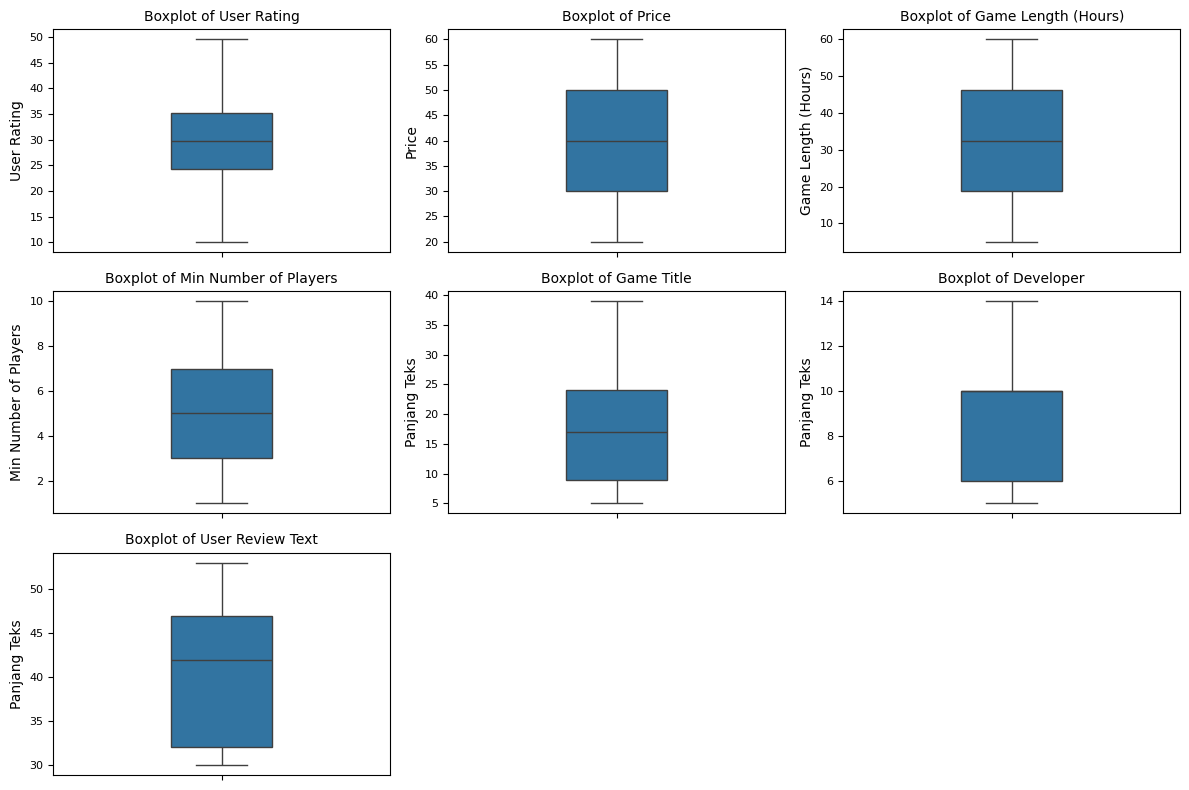

In [15]:
# Tentukan fitur-fitur yang ingin divisualisasikan
fitur = ['User Rating', 'Price', 'Game Length (Hours)', 'Min Number of Players',
         'Game Title', 'Developer', 'User Review Text']

# Atur ukuran grid plot (diperkecil)
fig, axes = plt.subplots(3, 3, figsize=(12, 8))  # Ukuran diperkecil dari 18x12

for i, fitur_name in enumerate(fitur):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    if fitur_name in ['Game Title', 'Developer', 'User Review Text']:
        # Hitung panjang karakter dari teks
        text_lengths = df[fitur_name].str.len()
        sns.boxplot(y=text_lengths, ax=ax, width=0.3)  # Lebar box dikurangi
        ax.set_ylabel('Panjang Teks')
    else:
        sns.boxplot(data=df, y=fitur_name, ax=ax, width=0.3)  # Lebar box dikurangi
        ax.set_ylabel(fitur_name)

    ax.set_title(f'Boxplot of {fitur_name}', fontsize=10)  # Judul lebih kecil
    ax.tick_params(axis='y', labelsize=8)

# Hapus subplot kosong jika ada
if len(fitur) < 9:
    for j in range(len(fitur), 9):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

Berikut ini penjelasan dari masing-masing box plot:

**1. Boxplot of User Rating**
- Menampilkan distribusi nilai rating dari pengguna untuk masing-masing game.
- Median sekitar 32–35, menunjukkan rating rata-rata pengguna ada di rentang tersebut.
- Terlihat adanya outlier di bawah 15 dan di atas 45, yang menunjukkan bahwa sebagian kecil game memiliki rating sangat rendah atau sangat tinggi.
- Sebaran data cukup merata namun condong ke tengah, mencerminkan variasi penilaian pengguna.

**2. Boxplot of Price**
- Menampilkan distribusi harga dari game.
- Median harga berada di sekitar 40–45.
- Terdapat outlier di bawah 25 dan di atas 55–60, menunjukkan adanya game yang sangat murah maupun sangat mahal.
- Distribusinya cukup lebar, mencerminkan adanya perbedaan harga yang signifikan antar game.

**3. Boxplot of Game Length (Hours)**
- Menampilkan sebaran durasi gameplay atau lamanya game dimainkan.
- Median berada di sekitar 30 jam, menandakan sebagian besar game berdurasi cukup panjang.
- Terdapat outlier di kedua sisi, menunjukkan beberapa game yang sangat singkat maupun sangat panjang.
- Rentang interkuartil yang lebar menunjukkan variasi yang besar dalam durasi game.

**4. Boxplot of Min Number of Players**
- Menampilkan jumlah minimal pemain yang dibutuhkan untuk memainkan game.
- Median berada di 5–6 pemain, artinya kebanyakan game dirancang untuk dimainkan dalam grup.
- Terlihat outlier di bawah 2 dan di atas 8, yang menunjukkan adanya game yang bisa dimainkan solo maupun secara besar-besaran.
- Variasi antar game cukup jelas, menunjukkan beragam gaya bermain yang ditawarkan.

**5. Boxplot of Game Title (Panjang Teks)**
- Mengukur panjang karakter nama game (bukan isi game-nya).
-Median panjang judul game berada di sekitar 18–20 karakter.
- Beberapa game memiliki judul sangat pendek (~ 5 karakter), dan beberapa cukup panjang (~ 40 karakter).
- Sebagian besar judul game memiliki panjang yang cukup moderat, menunjukkan konsistensi dalam penamaan.

**6. Boxplot of Developer (Panjang Teks)**
- Menampilkan panjang teks nama developer.
- Median berada di kisaran 8–9 karakter.
- Outlier menunjukkan adanya developer dengan nama sangat pendek (~5) dan sangat panjang (~14).
- Panjang nama developer relatif lebih konsisten dibandingkan panjang judul game.

**7. Boxplot of User Review Text (Panjang Teks)**
- Menggambarkan panjang teks ulasan dari pengguna dalam karakter.
- Median ulasan berada di kisaran 42–45 karakter, dengan variasi mulai dari 30 hingga 55+ karakter.
- Ini menunjukkan bahwa sebagian besar pengguna menulis ulasan singkat, kemungkinan berupa satu atau dua kalimat saja.
- Tidak ada outlier yang ekstrem, mencerminkan keseragaman dalam panjang review.

b. Menggunakan Histogram

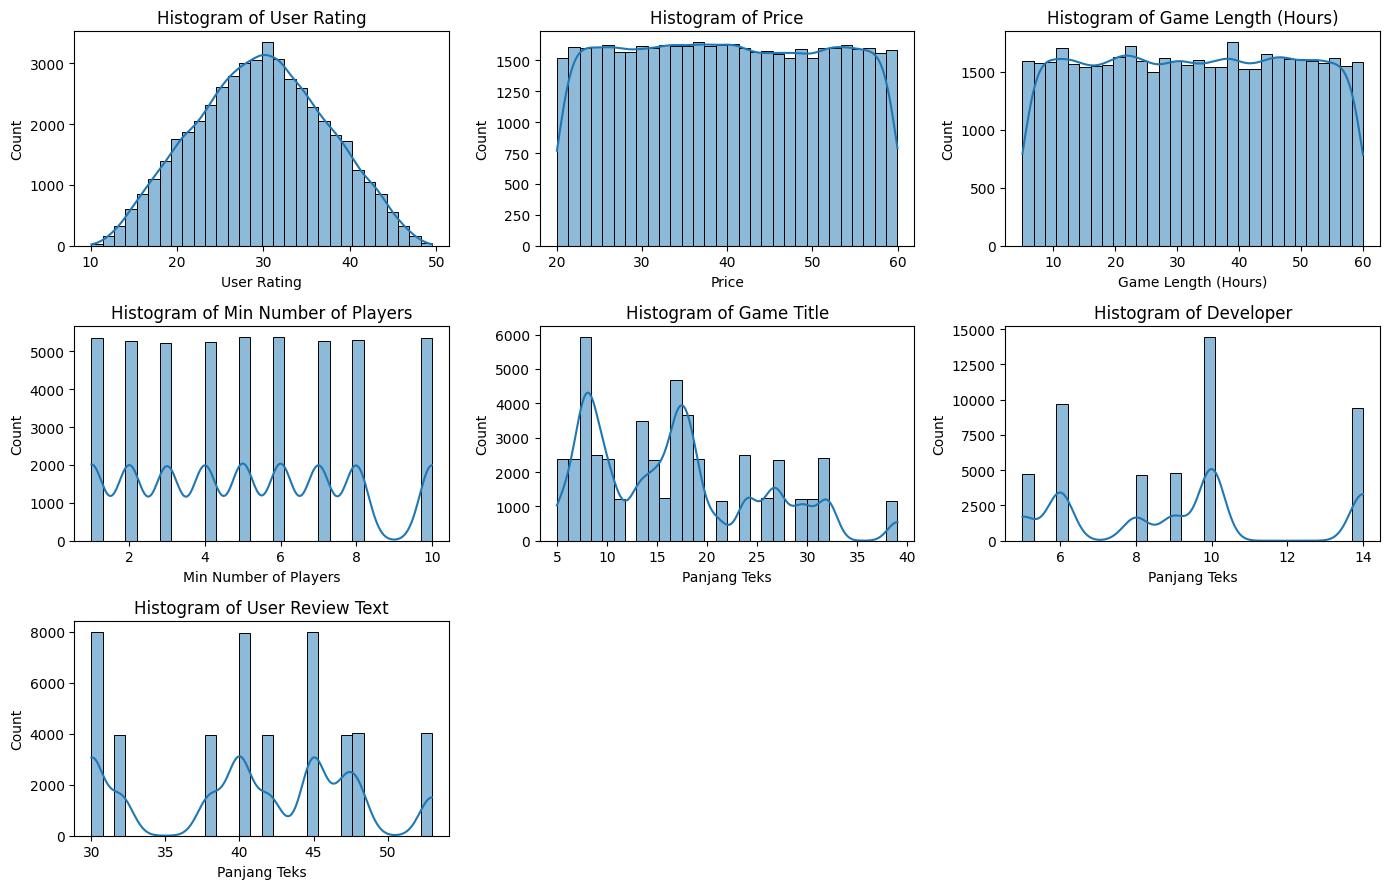

In [16]:
# Daftar fitur yang akan divisualisasikan
fitur = ['User Rating', 'Price', 'Game Length (Hours)', 'Min Number of Players',
         'Game Title', 'Developer', 'User Review Text']

# Buat plot histogram dengan ukuran yang lebih kecil
fig, axes = plt.subplots(3, 3, figsize=(14, 9))  # Diperkecil dari (18, 12)

for i, fitur_name in enumerate(fitur):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    if fitur_name in ['Game Title', 'Developer', 'User Review Text']:
        text_lengths = df[fitur_name].str.len()
        sns.histplot(text_lengths, bins=30, kde=True, ax=ax)
        ax.set_xlabel('Panjang Teks')
    else:
        sns.histplot(df[fitur_name], bins=30, kde=True, ax=ax)
        ax.set_xlabel(fitur_name)

    ax.set_title(f'Histogram of {fitur_name}')

# Hapus subplot kosong jika ada
if len(fitur) < 9:
    for j in range(len(fitur), 9):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

Berikut adalah penjelasan dari per subplot:

**1. User Rating**
- Histogram menunjukkan pola menyerupai kurva normal, dengan mayoritas rating berkumpul di sekitar nilai 30.
- Nilai rating tersebar dari sekitar 10 hingga 50, dan tidak ada dominasi pada skor rendah atau tinggi.

**2. Price**
- Nilai harga tersebar cukup merata di seluruh rentang, dari sekitar 20 hingga 60.
- Tidak terlihat adanya konsentrasi pada harga tertentu, menunjukkan game berasal dari berbagai segmen harga.

**3. Game Length (Hours)**
- Panjang waktu bermain game tersebar di kisaran 0 hingga 60 jam, dengan jumlah game relatif seragam di berbagai durasi.
- Terdapat sedikit konsentrasi pada jam-jam tertentu, namun secara umum cukup bervariasi.

**4. Min Number of Players**
- Nilai minimum pemain cenderung diskrit dan merata dari 1 hingga 10.
- Tidak ada angka jumlah pemain minimum yang secara mencolok mendominasi.

**5. Game Title (Panjang Teks)**
- Panjang karakter judul game bervariasi dari sekitar 5 hingga 40 karakter.
- Beberapa puncak frekuensi muncul di sekitar panjang 10, 15, dan 25 karakter.

**6. Developer (Panjang Teks)**
- Nama pengembang memiliki panjang teks yang tersebar dari sekitar 5 hingga 14 karakter.
- Terlihat puncak pada panjang tertentu, menandakan banyak developer menggunakan nama dengan panjang khas.

**7. User Review Text (Panjang Teks)**
- Panjang ulasan pengguna berkisar antara 30 hingga 55 karakter.
- Beberapa panjang teks muncul lebih sering, menunjukkan kecenderungan pengguna menulis ulasan dengan panjang tertentu.

## e. Visualisasi Multivariative

a. Matriks Korelasi

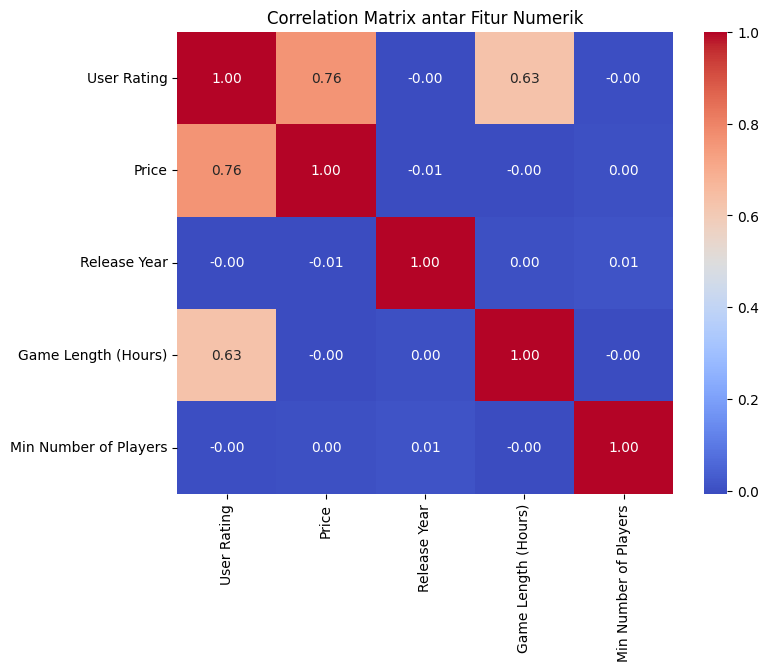

In [17]:
# Ambil hanya kolom numerik
numerik_df = df.select_dtypes(include=['int64', 'float64'])

# Hitung korelasi
corr_matrix = numerik_df.corr()

# Visualisasikan dengan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix antar Fitur Numerik')
plt.show()

Berikut penjelasan singkat dari korelasi matriks:

**1. User Rating**
- Memiliki korelasi positif yang kuat dengan Price (0.76), menunjukkan bahwa game dengan rating tinggi cenderung memiliki harga yang lebih tinggi.
- Juga berkorelasi positif dengan Game Length (Hours) (0.63), yang berarti game dengan durasi lebih panjang cenderung mendapat rating lebih baik.
- Tidak menunjukkan hubungan berarti dengan Release Year atau Min Number of Players.

**2. Price**
- Memiliki korelasi positif yang kuat dengan User Rating (0.76), menandakan bahwa game yang lebih mahal umumnya memiliki rating lebih tinggi.
- Tidak memiliki hubungan signifikan dengan fitur lainnya seperti Release Year, Game Length (Hours), atau Min Number of Players.

**3. Release Year**
- Tidak memiliki korelasi yang berarti dengan fitur lainnya.
- Nilai korelasi sangat mendekati nol, menunjukkan bahwa tahun rilis tidak berkaitan kuat dengan rating, harga, durasi main, maupun jumlah pemain minimum.

**4. Game Length (Hours)**
- Berkorelasi positif dengan User Rating (0.63), artinya game yang berdurasi lebih panjang cenderung mendapatkan penilaian lebih baik dari pengguna.
- Korelasinya dengan fitur lain sangat lemah atau mendekati nol.

**5. Min Number of Players**
- Tidak menunjukkan hubungan korelasi yang signifikan dengan fitur numerik lainnya.
- Nilai korelasinya mendekati nol di semua pasangan fitur.

b. Pairplot

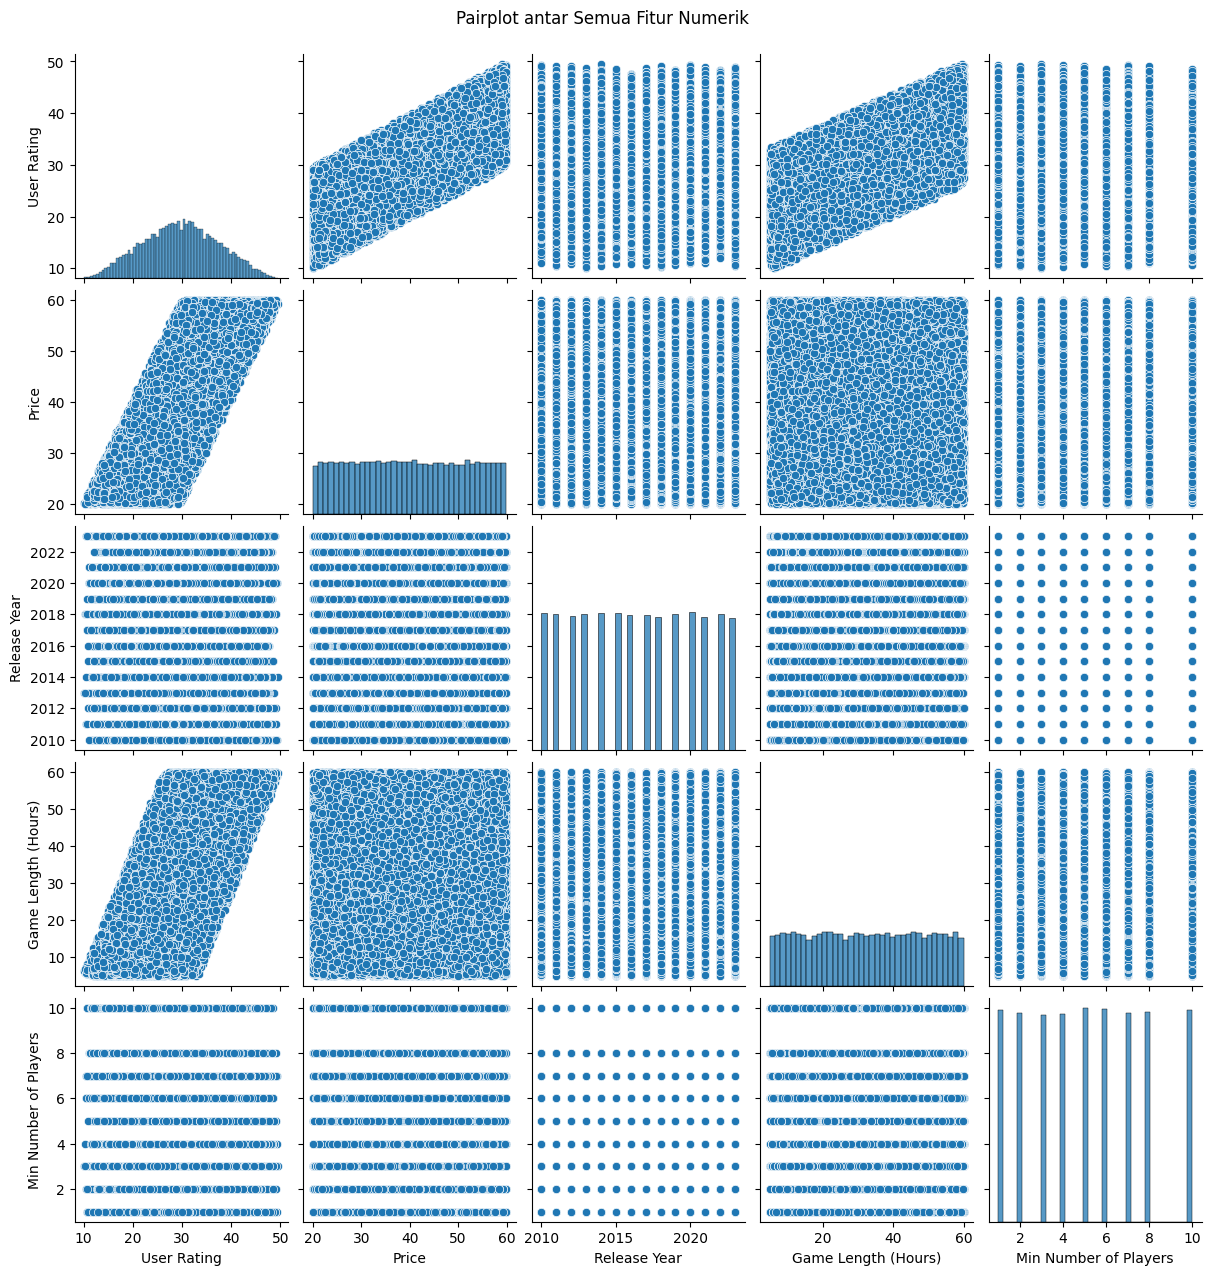

In [18]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

sns.pairplot(df[numeric_cols])
plt.suptitle("Pairplot antar Semua Fitur Numerik", y=1.02)
plt.show()

Berikut adalah penjelasan Scatter Plot antar Variabel:

**1. User Rating vs Price**
- Scatter plot menunjukkan pola linier positif yang kuat, mengindikasikan bahwa semakin tinggi rating sebuah game, semakin mahal pula harganya.
- Ini mendukung hasil korelasi sebelumnya (r = 0.76).

**2. User Rating vs Game Length (Hours)**
- Terlihat pola linier positif: game dengan durasi bermain lebih lama cenderung memiliki rating lebih tinggi.
- Sebagian besar titik membentuk diagonal yang naik, mendukung korelasi positif sebelumnya (r = 0.63).

**3. User Rating vs Release Year / Min Number of Players**
- Titik-titik terlihat tersebar tanpa pola jelas, menandakan tidak ada korelasi signifikan.
- Ini sesuai dengan nilai korelasi mendekati nol pada heatmap.

**4. Price vs Game Length (Hours)**
- Tidak tampak pola yang konsisten atau jelas.
- Titik tersebar secara acak, mendukung asumsi tidak ada hubungan kuat antara harga game dan durasi mainnya.

**5. Release Year vs Fitur Lain**
- Sebagian besar plot terhadap Release Year menunjukkan sebaran horizontal atau vertikal garis-garis.
- Ini karena Release Year bersifat diskrit dan terbatas (sekitar 2010–2022), sehingga tidak menunjukkan pola korelatif berarti terhadap fitur lainnya.

**6. Min Number of Players vs Fitur Lain**
- Scatter plot tampak tersegmentasi dalam barisan vertikal, karena data bersifat diskrit/kategori numerik (1–10 pemain).
- Tidak ada indikasi pola linier atau korelasi yang kuat dengan fitur lainnya.

**7. Diagonal Histogram**
- Memberikan gambaran distribusi setiap fitur:
  - User Rating, Distribusi mirip kurva normal.
  - Price, Cenderung merata, meskipun sedikit condong ke sisi tengah.
  - Release Year, Data tersebar merata dari 2010–2022.
  - Game Length, Menunjukkan sebaran seragam.
  - Min Number of Players, Bertingkat karena data diskrit.


Top 10 nilai terbanyak di kolom 'Genre':
- RPG: 4873
- Shooter: 4869
- Strategy: 4867
- Puzzle: 4822
- Simulation: 4784
- Adventure: 4750
- Party: 4748
- Sports: 4735
- Fighting: 4687
- Action: 4639


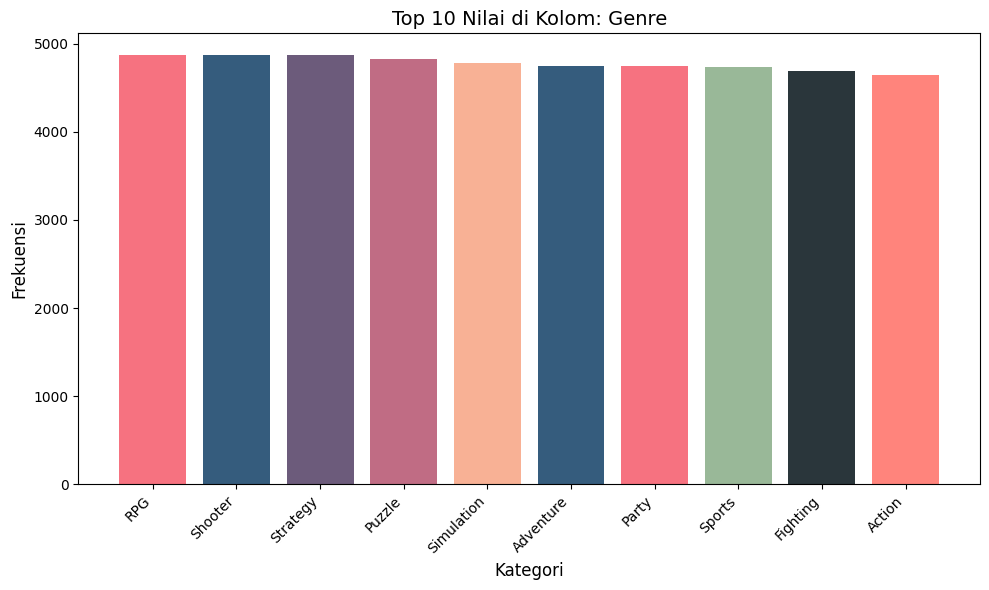


Top 10 nilai terbanyak di kolom 'Platform':
- PlayStation: 9633
- PC: 9599
- Nintendo Switch: 9596
- Mobile: 9589
- Xbox: 9357


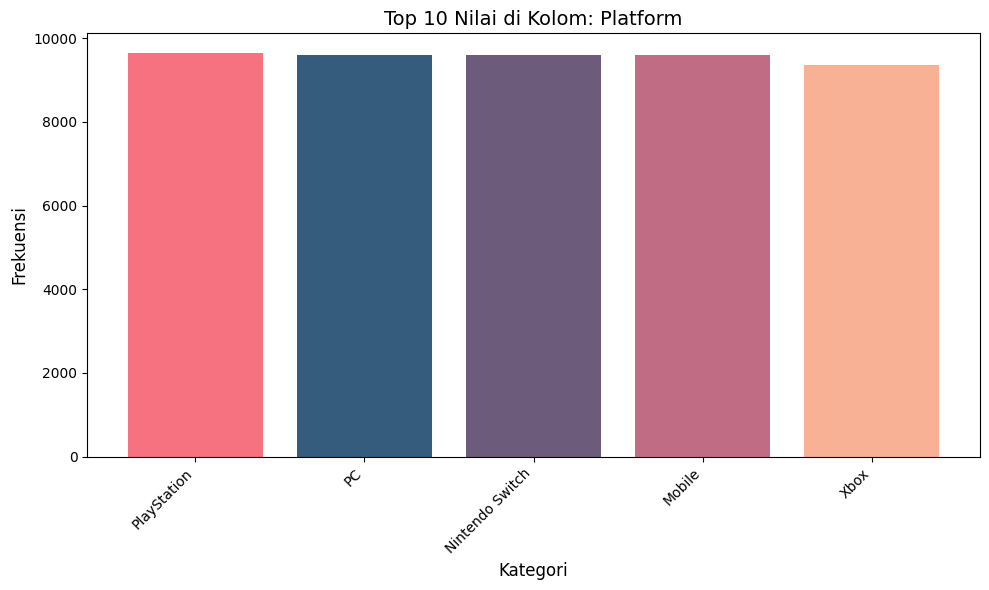


Top 10 nilai terbanyak di kolom 'Game Mode':
- Offline: 23957
- Online: 23817


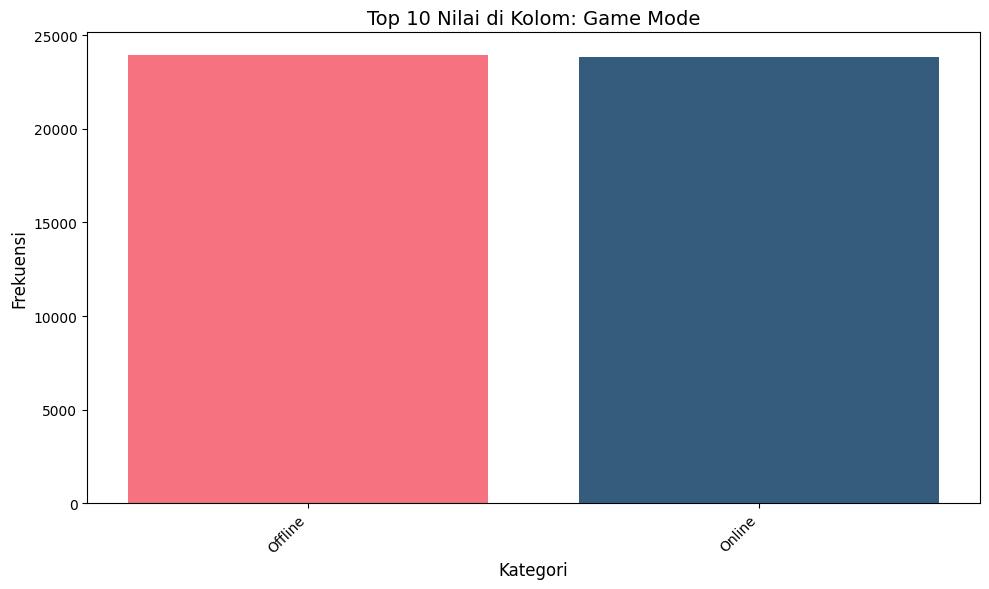


Top 10 nilai terbanyak di kolom 'Publisher':
- Capcom: 5406
- Electronic Arts: 5382
- Activision: 5360
- Epic Games: 5353
- Valve: 5316
- Take-Two Interactive: 5269
- Square Enix: 5262
- Nintendo: 5226
- Innersloth: 5200


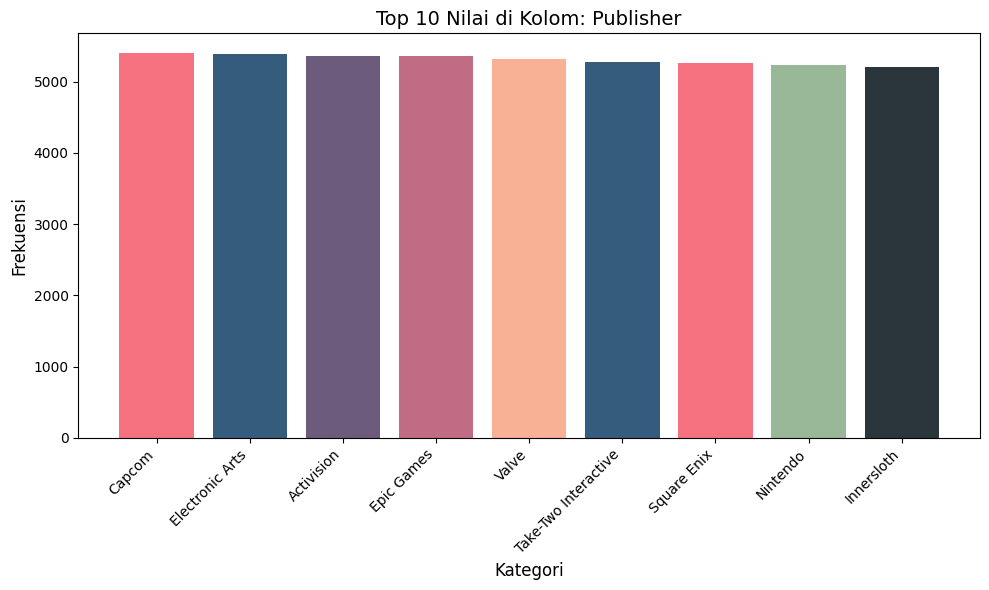

In [19]:
def plot_top_values(df, column_name, top_n=10):
    """
    Menampilkan dan memvisualisasikan nilai-nilai teratas (top_n) yang paling sering muncul
    dalam kolom kategorikal bertipe object (misal: Genre, Platform, Developer).

    Args:
        df: pandas DataFrame.
        column_name: Nama kolom bertipe object.
        top_n: Jumlah nilai teratas yang akan ditampilkan (default: 10).
    """
    all_values = []

    # Pisahkan jika isinya ada koma (multi-label seperti 'Action, Adventure')
    for value in df[column_name]:
        all_values.extend([v.strip() for v in value.split(',')])

    # Hitung frekuensi setiap nilai unik
    value_counts = Counter(all_values)
    top_values = value_counts.most_common(top_n)

    # Print nilai-nilai teratas
    print(f"\nTop {top_n} nilai terbanyak di kolom '{column_name}':")
    for value, count in top_values:
        print(f"- {value}: {count}")

    # Warna visual yang menarik
    colors = ['#F67280', '#355C7D', '#6C5B7B', '#C06C84', '#F8B195',
              '#355C7D', '#F67280', '#99B898', '#2A363B', '#FF847C']

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar([val[0] for val in top_values], [val[1] for val in top_values], color=colors[:top_n])
    plt.title(f'Top {top_n} Nilai di Kolom: {column_name}', fontsize=14)
    plt.xlabel('Kategori', fontsize=12)
    plt.ylabel('Frekuensi', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_top_values(df, 'Genre')
plot_top_values(df, 'Platform')
plot_top_values(df, 'Game Mode')
plot_top_values(df, 'Publisher')

🎮 Insight Top 10 Genre:
- Semua genre yang muncul merupakan genre populer lintas platform dan usia, menunjukkan bahwa dataset ini mencerminkan pasar game yang luas dan beragam.

- RPG, Shooter, dan Strategy menempati posisi teratas, mengindikasikan tingginya minat pengguna pada genre dengan gameplay kompleks, kompetitif, dan berbasis narasi.

- Perbedaan frekuensi antar genre sangat kecil (selisih hanya puluhan), menandakan bahwa preferensi genre dari pengguna cukup merata, tidak terlalu terpusat pada satu jenis saja.

- Genre seperti Puzzle, Simulation, dan Adventure juga muncul tinggi, mencerminkan permintaan signifikan terhadap game yang bersifat santai, eksploratif, atau berbasis logika.

- Hadirnya Party dan Sports menunjukkan bahwa game dengan elemen multiplayer kasual atau kompetitif tetap diminati, khususnya dalam konteks game sosial atau keluarga.

- Genre Fighting dan Action tetap stabil di posisi 9 dan 10, menandakan mereka masih menjadi pilar utama industri game meski tidak dominan secara absolut.

🕹️ Insight Top 5 Platform:
- PlayStation, PC, dan Nintendo Switch menempati posisi teratas dengan jumlah yang sangat berdekatan, menandakan bahwa dataset ini mencakup spektrum platform yang luas dan seimbang di antara console dan PC.

- Mobile memiliki frekuensi tinggi (9589), menunjukkan bahwa mobile gaming merupakan bagian penting dalam ekosistem game modern, sejalan dengan tren global meningkatnya game berbasis Android/iOS.

- Xbox berada sedikit di bawah empat platform lainnya, namun tetap menempati posisi 5 besar—menunjukkan bahwa platform ini juga sangat relevan dalam distribusi dan review game dalam dataset ini.

- Perbedaan angka yang tipis antar kelima platform mengindikasikan bahwa game development dan distribusi kini bersifat multiplatform, dan tidak lagi didominasi satu jenis perangkat saja.

- Distribusi yang merata ini juga membuat dataset sangat cocok untuk membangun sistem rekomendasi yang tidak bias terhadap satu platform, serta mampu menyarankan game berdasarkan preferensi lintas perangkat.

🌐 Insight Game Mode:
- Dataset menunjukkan pembagian yang hampir seimbang antara game Offline (23.957) dan Online (23.817), dengan selisih yang sangat kecil.

- Hal ini mengindikasikan bahwa kedua mode permainan sama-sama populer, dan pengembang game cenderung menyediakan opsi bermain baik secara online maupun offline untuk menjangkau audiens yang lebih luas.

- Offline games mungkin tetap populer karena faktor aksesibilitas tanpa internet, gameplay berbasis cerita (single-player), serta kenyamanan bermain pribadi.

- Online games mencerminkan tren sosial dan kompetitif yang semakin berkembang—baik dalam bentuk multiplayer, co-op, atau fitur live service.

- Distribusi ini sangat ideal untuk sistem rekomendasi karena memungkinkan pengguna memilih mode game berdasarkan ketersediaan koneksi, preferensi bermain, atau perangkat.

🏢 Insight Top 10 Publisher:
- Publisher-publisher besar seperti Capcom, Electronic Arts (EA), Activision, dan Epic Games mendominasi daftar teratas, menunjukkan bahwa dataset ini berasal dari game-game terkenal yang dirilis oleh perusahaan AAA (high-budget).

- Selisih angka yang sangat kecil antar publisher (rata-rata hanya puluhan) mengindikasikan bahwa representasi data cukup merata, tidak didominasi oleh satu entitas besar.

- Kehadiran Valve dan Nintendo menguatkan bahwa PC dan konsol eksklusif seperti Switch memiliki tempat penting di pasar, sesuai juga dengan hasil dari distribusi Platform sebelumnya.

- Take-Two Interactive dan Square Enix mengindikasikan banyaknya game bergenre RPG, simulasi, dan open-world, yang umumnya dikembangkan oleh publisher ini.

- Menariknya, Innersloth—meskipun merupakan publisher indie kecil (dikenal dari Among Us)—muncul di peringkat 10 besar, mencerminkan besarnya pengaruh game indie tertentu yang viral dan mendapatkan banyak ulasan.

- Insight ini mendukung pemodelan sistem rekomendasi berdasarkan nama publisher, karena tiap publisher punya gaya dan kualitas game yang khas, dan ini bisa menjadi indikator relevan untuk rekomendasi.

# Data Preparation

In [20]:
for i, (nama_kolom, jumlah) in enumerate(df.count().items(), 1):
  print(f'Kolom {i}: {nama_kolom} - Berjumlah: {jumlah}')

Kolom 1: Game Title - Berjumlah: 47774
Kolom 2: User Rating - Berjumlah: 47774
Kolom 3: Age Group Targeted - Berjumlah: 47774
Kolom 4: Price - Berjumlah: 47774
Kolom 5: Platform - Berjumlah: 47774
Kolom 6: Requires Special Device - Berjumlah: 47774
Kolom 7: Developer - Berjumlah: 47774
Kolom 8: Publisher - Berjumlah: 47774
Kolom 9: Release Year - Berjumlah: 47774
Kolom 10: Genre - Berjumlah: 47774
Kolom 11: Multiplayer - Berjumlah: 47774
Kolom 12: Game Length (Hours) - Berjumlah: 47774
Kolom 13: Graphics Quality - Berjumlah: 47774
Kolom 14: Soundtrack Quality - Berjumlah: 47774
Kolom 15: Story Quality - Berjumlah: 47774
Kolom 16: User Review Text - Berjumlah: 47774
Kolom 17: Game Mode - Berjumlah: 47774
Kolom 18: Min Number of Players - Berjumlah: 47774


Dataset ini terdiri dari 47.774 baris data dan 18 kolom fitur, yang masing-masing merepresentasikan karakteristik penting dari sebuah video game.

In [21]:
df

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47769,Minecraft,41.6,All Ages,49.11,PlayStation,Yes,Valve,Innersloth,2016,Party,No,56.7,Low,Excellent,Average,"Amazing game, but the graphics could be better.",Online,4
47770,The Legend of Zelda: Breath of the Wild,24.2,Kids,31.69,Xbox,Yes,Valve,Electronic Arts,2023,Strategy,No,29.7,High,Good,Excellent,"Solid game, but the graphics could be better.",Offline,1
47771,Animal Crossing: New Horizons,26.7,All Ages,44.90,PlayStation,Yes,Game Freak,Square Enix,2018,Sports,No,8.2,Low,Poor,Good,"Great game, but the gameplay is amazing.",Offline,5
47772,The Legend of Zelda: Breath of the Wild,22.5,Kids,29.99,Xbox,Yes,Epic Games,Epic Games,2018,Simulation,Yes,29.7,High,Poor,Excellent,"Disappointing game, but the graphics could be ...",Offline,1


## **TF-IDF**

In [22]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tf.fit(df['User Review Text'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['amazing', 'be', 'better', 'bugs', 'but', 'could', 'disappointing',
       'game', 'gameplay', 'graphics', 'great', 'is', 'many', 'solid',
       'the', 'too'], dtype=object)

- TfidfVectorizer() adalah alat dari scikit-learn untuk mengubah teks menjadi representasi numerik berbasis TF-IDF (Term Frequency–Inverse Document Frequency), yang digunakan untuk menilai seberapa penting sebuah kata dalam dokumen relatif terhadap keseluruhan korpus.
- Proses ini melatih vectorizer dengan seluruh teks ulasan pengguna dari kolom 'User Review Text'.
- Hasilnya, setiap kata yang muncul dalam teks akan dicatat dan diberi skor IDF (yang menggambarkan pentingnya kata itu dalam semua review).
- Mengembalikan array dari kata-kata unik (vocabulary) yang dikenali oleh TF-IDF berdasarkan data yang telah dilatih.
- Ini mewakili fitur-fitur teks yang nantinya bisa digunakan untuk analisis lanjutan seperti klasifikasi, clustering, atau rekomendasi berbasis konten.

Ini adalah daftar kata-kata penting (fitur teks) yang diekstraksi dari ulasan pengguna setelah proses tokenisasi dan filtering oleh TF-IDF.
Misalnya:
- ‘amazing’, ‘great’, ‘solid’ -> bisa menunjukkan ulasan positif.
- ‘disappointing’, ‘bugs’ -> indikasi ulasan negatif.
- ‘graphics’, ‘gameplay’, ‘story’ -> topik yang sering dibahas.

In [23]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(df['User Review Text'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(47774, 16)

- Matriks ini memiliki 47.774 baris -> sesuai jumlah total ulasan pengguna.
- Dan 16 kolom -> hanya ada 16 kata unik yang dipertahankan sebagai fitur teks (seperti: amazing, bugs, gameplay, great, disappointing, dll).

In [24]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.52164191, 0.        ,
         0.45907995],
        [0.        , 0.        , 0.        , ..., 0.52164191, 0.        ,
         0.45907995],
        [0.        , 0.40167772, 0.40167772, ..., 0.        , 0.26929629,
         0.        ],
        ...,
        [0.36721028, 0.        , 0.        , ..., 0.        , 0.30401893,
         0.        ],
        [0.        , 0.40173343, 0.40173343, ..., 0.        , 0.26933364,
         0.        ],
        [0.34340419, 0.42407118, 0.42407118, ..., 0.        , 0.28430951,
         0.        ]])

- Fungsi .todense() digunakan untuk mengonversi matriks TF-IDF yang sebelumnya dalam bentuk sparse matrix menjadi dense matrix (matriks penuh).
- Dense matrix ini berisi angka-angka desimal yang merepresentasikan skor TF-IDF dari setiap kata dalam setiap dokumen (ulasan).
- Setiap baris mewakili satu ulasan pengguna.
- Nilai-nilainya adalah bobot pentingnya kata tersebut dalam ulasan itu, dihitung menggunakan TF-IDF.

In [25]:
# Membuat dataframe untuk melihat tf-idf matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=df['Game Title']
).sample(10, axis=1).sample(10, axis=0)

,disappointing,the,many,could,gameplay,but,amazing,solid,too,bugs
Game Title,,,,,,,,,,
Sid Meier’s Civilization VI,0.456514,0.269334,0.000000,0.401733,0.000000,0.191697,0.000000,0.000000,0.000000,0.000000
Grand Theft Auto V,0.000000,0.284910,0.000000,0.000000,0.425960,0.202784,0.688259,0.000000,0.000000,0.000000
Tomb Raider (2013),0.515395,0.304073,0.000000,0.000000,0.454609,0.216423,0.367275,0.000000,0.000000,0.000000
Mario Kart 8 Deluxe,0.000000,0.304019,0.000000,0.000000,0.454529,0.216384,0.367210,0.000000,0.000000,0.000000
League of Legends,0.000000,0.303931,0.000000,0.000000,0.454397,0.216322,0.367104,0.516058,0.000000,0.000000
Tekken 7,0.520977,0.000000,0.459299,0.000000,0.000000,0.218767,0.000000,0.000000,0.459299,0.459299
The Elder Scrolls V: Skyrim,0.000000,0.284310,0.000000,0.424071,0.000000,0.202356,0.343404,0.000000,0.000000,0.000000
Tekken 7,0.000000,0.269296,0.000000,0.401678,0.000000,0.191671,0.000000,0.000000,0.000000,0.000000
Fall Guys,0.000000,0.304019,0.000000,0.000000,0.454529,0.216384,0.367210,0.000000,0.000000,0.000000


In [26]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix[:1000], tfidf_matrix[:1000])

- Fungsi cosine_similarity dari sklearn.metrics.pairwise digunakan untuk menghitung kemiripan antar dokumen teks (dalam hal ini ulasan game).
- tfidf_matrix[:1000] berarti kita hanya mengambil 1.000 ulasan pertama untuk dihitung kemiripannya.

# Modeling

In [27]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['Game Title'][:1000], columns=df['Game Title'][:1000])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1000, 1000)


Game Title,League of Legends,Pokémon Scarlet & Violet,Halo Infinite,Tetris,Spelunky 2
Game Title,,,,,
Tekken 7,0.321921,0.090096,0.400344,0.791196,0.791486
Kingdom Hearts III,1.000000,0.782598,0.363429,0.083828,0.083859
FIFA 24,0.094631,0.248102,0.733896,0.400650,0.164796
Pokémon Scarlet & Violet,0.728105,0.782366,0.094630,0.322270,0.083834
The Sims 4,0.782598,1.000000,0.248174,0.090075,0.090108
Kingdom Hearts III,0.083828,0.090075,0.164783,1.000000,0.791306
The Sims 4,0.094631,0.248102,0.733896,0.400650,0.164796
Call of Duty: Modern Warfare 2,0.088522,0.232085,0.300111,0.835305,0.835611
Minecraft,0.363429,0.248174,1.000000,0.164783,0.164843


Matriksnya berbentuk 1000 × 1000, yang artinya kita membandingkan semua 1.000 game terhadap satu sama lain.


In [28]:
def recommend_games(game_title, df, cosine_sim, top_n=10):
    # Pastikan game_title ada di dataframe
    if game_title not in df['Game Title'].values:
        return f"Game '{game_title}' tidak ditemukan dalam dataset."

    # Ambil index game yang dimaksud
    idx = df.index[df['Game Title'] == game_title][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    game_indices = [i[0] for i in sim_scores]
    rekomendasi = df.iloc[game_indices][['Game Title', 'Genre']].copy()
    rekomendasi.rename(columns={'Genre': 'Game Genre'}, inplace=True)

    return rekomendasi.reset_index(drop=True)


- Fungsi ini sangat tepat untuk sistem rekomendasi berbasis konten (content-based filtering).
- Menggunakan ulasan pengguna sebagai dasar kemiripan memungkinkan sistem merekomendasikan game yang memiliki nuansa dan pengalaman bermain yang serupa, bukan hanya berdasarkan genre atau developer.
- Bisa dikembangkan lagi dengan menambahkan info lain seperti harga, platform, atau rating dalam hasil rekomendasinya.

In [29]:
recommend_games('Grand Theft Auto V', df, cosine_sim, top_n=10)

,Game Title,Game Genre
0,The Sims 4,Shooter
1,Street Fighter V,Fighting
2,Pillars of Eternity II: Deadfire,Puzzle
3,The Elder Scrolls V: Skyrim,Action
4,Minecraft,Party
5,Hades,Puzzle
6,Halo Infinite,Action
7,Half-Life: Alyx,Action
8,Mario Kart 8 Deluxe,Adventure
9,Super Mario Odyssey,Fighting


Fungsi ini mencari 10 game teratas yang paling mirip dengan Grand Theft Auto V, berdasarkan ulasan pengguna yang telah dikonversi menjadi representasi vektor menggunakan TF-IDF, lalu dibandingkan menggunakan cosine similarity.

# Evaluation

In [30]:
# Hitung sparsity
sparsity = (1.0 - tfidf_matrix.count_nonzero() / float(tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100
print(f"Sparsity dari TF-IDF matrix: {sparsity:.2f}%")

Sparsity dari TF-IDF matrix: 56.76%


- Sparsity 56.76% artinya lebih dari setengah elemen dalam matriks TF-IDF adalah nol, alias tidak semua kata muncul di setiap ulasan.
- Ini normal dan umum dalam data teks, karena:
  - Setiap ulasan pengguna cenderung pendek dan spesifik,
  - Hanya menggunakan sebagian kecil dari seluruh kosa kata yang ada.
- Sparsity ini aman dan menunjukkan bahwa TF-IDF bekerja sebagaimana mestinya, menyaring informasi penting saja.

In [31]:
def recommend_games_safe(title, cosine_sim_matrix, df, top_n=5):
    if title not in df['Game Title'].values[:1000]:
        print(f"Game '{title}' tidak termasuk dalam 1000 data pertama yang diproses.")
        return None

    idx = df[df['Game Title'] == title].index[0]

    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil top_n rekomendasi, skip indeks dirinya sendiri
    sim_scores = [x for x in sim_scores if x[0] != idx][:top_n]

    recommendations = pd.DataFrame({
        'Game Title': [df.iloc[i]['Game Title'] for i, _ in sim_scores],
        'Similarity Score': [score for _, score in sim_scores]
    })
    return recommendations

In [32]:
recommend_games_safe("Minecraft", cosine_sim, df)

,Game Title,Similarity Score
0,Spelunky 2,1.0
1,Hades,1.0
2,Fortnite,1.0
3,Tomb Raider (2013),1.0
4,The Sims 4,1.0


- Semua skor similarity = 1.0, artinya TF-IDF dari review text untuk game-game ini identik atau sangat-sangat mirip dengan Minecraft dalam 1000 data yang diproses.
- Kemungkinan besar terjadi karena:
  - Review pengguna yang terlalu umum, seperti “great game”, “good graphics”, “fun to play”, dsb.
  - Jumlah fitur TF-IDF hanya 16 kata unik, jadi representasi game menjadi terlalu sederhana dan banyak game yang tampak “sama”.

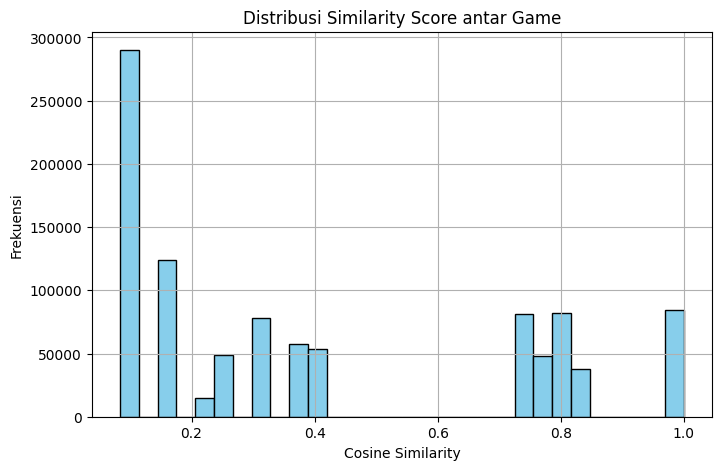

In [33]:
# Ambil similarity antar item (hanya dari subset jika besar)
similarities = cosine_sim.flatten()

plt.figure(figsize=(8,5))
plt.hist(similarities, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Similarity Score antar Game')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

Insight dari visualisasi diatas adalah:
1. Mayoritas Pasangan Game Tidak Terlalu Mirip
- Puncak distribusi berada di rentang 0.0–0.2, menunjukkan bahwa sebagian besar pasangan game memiliki kesamaan konten yang sangat rendah.
- Ini wajar, mengingat dataset game biasanya sangat beragam dalam genre, tema, dan fitur deskriptif lainnya.
2. Distribusi Bimodal
- Terdapat dua kelompok besar:
  - Kelompok besar pertama dengan similarity rendah (0.0–0.2).
  - Kelompok kedua dengan similarity tinggi (sekitar 0.75–1.0).
- Ini bisa menunjukkan bahwa beberapa game memang memiliki kemiripan konten yang kuat — misalnya, game dengan genre atau tema yang sangat mirip (misal: sekuel atau franchise).
3. Similarity Tinggi yang Signifikan
- Lonjakan di area 0.95–1.0 menandakan adanya game yang sangat identik atau hampir sama dari segi deskripsi kontennya. Ini bisa saja karena:
  - Game duplikat di dataset.
  - Game dengan variasi judul yang berbeda tetapi konten sangat mirip.
4. Sebaran yang Tidak Merata
- Gap besar antara similarity menengah (sekitar 0.5–0.7) mengindikasikan bahwa hanya sedikit game yang “cukup mirip”. Artinya, konten game cenderung ekstrem: sangat mirip atau sangat berbeda.

In [63]:
def evaluate_genre_match_safe(game_title, df, cosine_sim, top_n=5):
    subset_df = df.iloc[:1000]

    # Cek apakah game ada dalam subset
    if game_title not in subset_df['Game Title'].values:
        print(f"Game '{game_title}' tidak ditemukan di 1000 data pertama.")
        return

    idx = subset_df[subset_df['Game Title'] == game_title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    game_genre = df.iloc[idx]['Genre']
    print(f"\n🎮 Game Asli: {game_title} | Genre: {game_genre}\n")

    match = 0
    for i, (rec_idx, score) in enumerate(sim_scores):
        rec_genre = df.iloc[rec_idx]['Genre']
        match_status = rec_genre == game_genre
        print(f"{i+1}. {df.iloc[rec_idx]['Game Title']} | Genre: {rec_genre} | Match: {match_status}")
        if match_status:
            match += 1

    print(f"\n✅ {match}/{top_n} rekomendasi memiliki genre yang sama.")

Mengevaluasi seberapa relevan rekomendasi berdasarkan kesamaan genre dengan game aslinya. Ini digunakan untuk memeriksa apakah sistem rekomendasi yang dibangun hanya fokus pada teks ulasan, juga secara tidak langsung konsisten dengan preferensi genre pengguna.

In [64]:
evaluate_genre_match_safe('Spelunky 2', df, cosine_sim, top_n=5)


🎮 Game Asli: Spelunky 2 | Genre: Adventure

1. 1000-Piece Puzzle | Genre: Party | Match: False
2. Mario Kart 8 Deluxe | Genre: RPG | Match: False
3. Tomb Raider (2013) | Genre: Adventure | Match: True
4. Hades | Genre: Puzzle | Match: False
5. Half-Life: Alyx | Genre: Adventure | Match: True

✅ 2/5 rekomendasi memiliki genre yang sama.


- Hanya 2 dari 5 rekomendasi memiliki genre yang sama dengan game asal (Adventure).
- Hal ini menunjukkan bahwa review user kadang lebih menyoroti pengalaman bermain (fun, immersive, bebas) daripada genre teknis (Adventure, RPG, Shooter, dll).